In [1]:
import os
import pandas as pd
import numpy as np
import random
import math
from sklearn.ensemble import GradientBoostingClassifier
import pickle
import matplotlib.pylab as plt
%matplotlib inline
from sklearn.naive_bayes import GaussianNB

In [2]:
np.set_printoptions(precision=4, threshold=np.inf)

In [3]:
file_path = './Data/days_after_mainshock_360/'

In [4]:
feat_columns = ['aftershock_mag', 'sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy', 'coulomb', 'maxshear', 'von']

In [5]:
add_self, add_sqrt, add_abs, add_physic, add_log = False, False, True, True, True

In [6]:
def get_filename(filepath = file_path):
    file_list = []
    for filename in os.listdir(filepath):
        if filename.find('-x2y-y2x-z2z.csv')==-1:
            file_list.append(filename)
    return file_list
file_list = get_filename()
print(len(file_list))

175


In [7]:
mag_range = [3.0, 5.0, 5.5, 6.0, 8.0]
dis_range = [0, 20, 40, 60, 100000]

In [8]:
def get_sample(file_list, col_list, filepath=file_path, add_self=add_self, add_sqrt=add_sqrt, add_abs=add_abs, add_physic=add_physic,add_log=add_log):
    new_col = ['aftershock_mag']
    if add_self:
        for col in col_list[1::]:
            new_col.append(col)
    if add_abs:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("abs_"+col)
    if add_sqrt:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("sqrt_"+col)
    if add_physic:
        for col in col_list[1::]:
            if col in ['coulomb', 'maxshear', 'von']:
                new_col.append('abs_'+col)
    if add_log:
        for col in col_list[1::]:
            if col in ['sxx', 'syy', 'szz', 'syz', 'sxz', 'sxy']:
                new_col.append("log_"+col)            
    raw_data = None  
    for file in file_list:
        main_Mag = float(file.strip('.csv').split('-')[1][1::])
        df = pd.read_csv(filepath+file, header=0)
        axis = np.where(np.isnan(df))
        if len(axis[0]) != 0:
            print("%s is wrong" % file)
            continue
        unique = df['aftershock_mag'].unique()
        if(len(unique)==1):
            continue
        
        index = len(df.columns)
        columns = df.columns.copy()
        for col in columns:
            df.insert(index, '-'+col, -df[col])
            df.insert(index+1, 'abs_'+col, abs(df[col]))
            df.insert(index+2, '-abs_'+col, -abs(df[col]))
            col_sqrt = df[col].apply(lambda x: math.sqrt(abs(x)))
            df.insert(index+3, 'sqrt_'+col, col_sqrt)
            df.insert(index+4, '-sqrt_'+col, -col_sqrt)
            col_log = df[col].apply(lambda x: np.log(abs(x)+1))
            df.insert(index+5, 'log_'+col, col_log)
            df.insert(index+6, '-log_'+col, -col_log)
            
        for idx in range(len(mag_range) - 1):
            if main_Mag >= mag_range[idx] and main_Mag < mag_range[idx+1]:
                break
        mainMag_oneHot = [[0]*(len(mag_range)-1)]
        mainMag_oneHot[0][idx] = 1
        mainMag_oneHot = mainMag_oneHot * len(df)
        index = len(df.columns)
        mainMag_oneHot = np.array(mainMag_oneHot)
        for idx in range(len(mag_range)-1):
            df.insert(index+idx, 'mainMag_oneHot_'+str(idx), mainMag_oneHot[:, idx])
        
        dis_oneHot = []
        for x, y in zip(df['x'].values, df['y'].values):
#             print(x, y)
            dis = math.sqrt(x*x + y*y)
            for idx in range(len(dis_range)-1):
                if dis >= dis_range[idx] and dis < dis_range[idx+1]:
                    break
            dis_oneHot_tmp = [0]*(len(dis_range)-1)
            dis_oneHot_tmp[idx] = 1
            dis_oneHot.append(dis_oneHot_tmp)

        index = len(df.columns)
        dis_oneHot = np.array(dis_oneHot)
        for idx in range(len(dis_range)-1):
            df.insert(index+idx, 'dis_oneHot_'+str(idx), dis_oneHot[:, idx])
        if raw_data is None:
            raw_data = df
        else:
            raw_data = raw_data.append(df)
    
    if raw_data is None:
        return raw_data
    if len(raw_data) == 0:
        return raw_data[new_col]

    for idx in range(len(mag_range)-1):
        new_col.append('mainMag_oneHot_'+str(idx))
    for idx in range(len(dis_range)-1):
        new_col.append('dis_oneHot_'+str(idx))
    
    raw_data = raw_data[new_col]
    return raw_data

In [9]:
cnt = len(file_list)
Index = [i for i in range(cnt)]
random.seed(21)
random.shuffle(Index)
print(Index)

[82, 48, 61, 69, 92, 164, 145, 7, 156, 117, 80, 144, 146, 123, 78, 6, 53, 103, 36, 95, 150, 1, 50, 81, 172, 88, 126, 51, 27, 143, 12, 45, 101, 136, 2, 132, 16, 170, 157, 115, 30, 151, 83, 90, 35, 56, 168, 58, 153, 24, 32, 79, 67, 89, 169, 65, 152, 133, 158, 137, 100, 33, 106, 4, 91, 166, 54, 140, 163, 85, 13, 139, 141, 75, 174, 44, 21, 23, 14, 110, 118, 77, 73, 28, 66, 76, 70, 148, 119, 161, 63, 20, 11, 160, 34, 98, 62, 40, 108, 64, 57, 165, 155, 52, 68, 18, 43, 125, 49, 105, 112, 128, 71, 15, 130, 93, 74, 167, 97, 96, 147, 114, 134, 86, 26, 25, 99, 19, 171, 120, 9, 47, 38, 124, 102, 87, 41, 116, 142, 31, 22, 39, 5, 159, 29, 127, 138, 84, 8, 113, 104, 111, 10, 154, 59, 37, 17, 109, 149, 94, 3, 0, 60, 135, 129, 46, 131, 121, 55, 122, 72, 162, 173, 107, 42]


In [10]:
from sklearn import metrics as sk_metrics

20151207-M7.2.csv is wrong
20011114-M7.8.csv is wrong
(296043, 24)
(69754, 24)


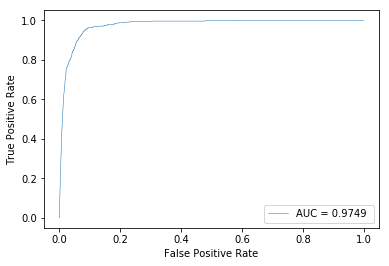

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
(302523, 24)
(63274, 24)


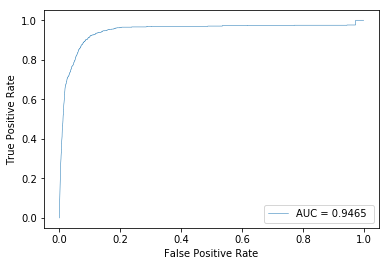

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
(282202, 24)
(83595, 24)


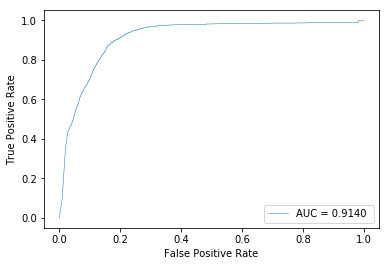

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
(286202, 24)
(79595, 24)


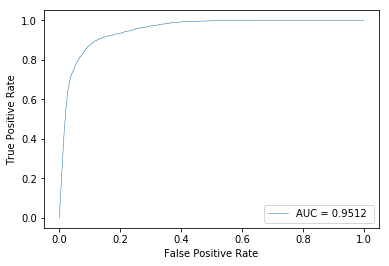

20011114-M7.8.csv is wrong
20151207-M7.2.csv is wrong
(296218, 24)
(69579, 24)


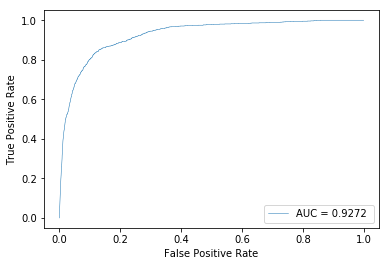

In [11]:
def main():
    fold_cnt = 5
    AUC_list = []
    Test_label_list,Test_predictProb_list = [], []
    for fold in range(fold_cnt):
        AUC = []
        columns=feat_columns
        group_cnt = len(file_list) // fold_cnt
        eval_Index = Index[fold*group_cnt:(fold+1)*group_cnt]
        train_Index = [idx for idx in Index if idx not in eval_Index]

        train_file = [file_list[idx] for idx in train_Index]
        eval_file = [file_list[idx] for idx in eval_Index]

        train_data = get_sample(train_file, columns)
        eval_data = get_sample(eval_file, columns)

        print(train_data.shape)
        print(eval_data.shape)

        train_data = train_data.values
        eval_data = eval_data.values

        np.random.shuffle(train_data)
        x_train = train_data[:, 1::]
        y_train = train_data[:, 0]
        y_train = (y_train>0).astype(int)

        x_test = eval_data[:, 1::]
        y_test = eval_data[:, 0]
        y_test = (y_test>0).astype(int)

        mean = np.mean(x_train, axis = 0)
        std = np.std(x_train, axis = 0)  
        x_train_std = (x_train - mean) / std
        x_test_std = (x_test - mean) / std

        model = GaussianNB()
        model.fit(x_train_std, y_train)

        y_pred = model.predict(x_test_std)
        y_predprob = model.predict_proba(x_test_std)[:,1]


        # print(predict)
        predict = y_predprob

        # draw the ROC 
        fpr, tpr, threshold = sk_metrics.roc_curve(y_test, predict)
        roc_auc = sk_metrics.roc_auc_score(y_test, predict)
        plt.plot(fpr, tpr,lw=0.5, label=('AUC = %0.4f ' %  roc_auc))
        plt.legend(loc = 'lower right')
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')

        AUC.append(roc_auc)

        Test_label_list.append(y_test)
        Test_predictProb_list.append(predict)
        plt.show()
        
        AUC_list.append(AUC)
    return Test_label_list,Test_predictProb_list, np.array(AUC_list)
Test_label_list,Test_predictProb_list, AUC_array = main()

In [12]:
print(np.mean(AUC_array)) 

0.9427394417041721
